In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load cifar-10-batches-py dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 → 8x8
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100. * correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_losses.append(val_loss / len(test_loader))
    val_acc.append(100. * correct / total)

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

Epoch 1: Train Loss: 1.5640, Train Acc: 42.73% | Val Loss: 1.2138, Val Acc: 56.42%
Epoch 2: Train Loss: 1.2642, Train Acc: 54.28% | Val Loss: 1.0814, Val Acc: 61.64%
Epoch 3: Train Loss: 1.1193, Train Acc: 60.00% | Val Loss: 0.9574, Val Acc: 66.06%
Epoch 4: Train Loss: 1.0375, Train Acc: 62.98% | Val Loss: 0.8958, Val Acc: 68.46%
Epoch 5: Train Loss: 0.9775, Train Acc: 65.38% | Val Loss: 0.8279, Val Acc: 71.58%
Epoch 6: Train Loss: 0.9278, Train Acc: 67.21% | Val Loss: 0.8234, Val Acc: 71.36%
Epoch 7: Train Loss: 0.9001, Train Acc: 68.18% | Val Loss: 0.7915, Val Acc: 72.44%
Epoch 8: Train Loss: 0.8609, Train Acc: 69.53% | Val Loss: 0.7589, Val Acc: 73.39%
Epoch 9: Train Loss: 0.8434, Train Acc: 70.28% | Val Loss: 0.7442, Val Acc: 74.13%
Epoch 10: Train Loss: 0.8199, Train Acc: 71.06% | Val Loss: 0.7181, Val Acc: 74.84%


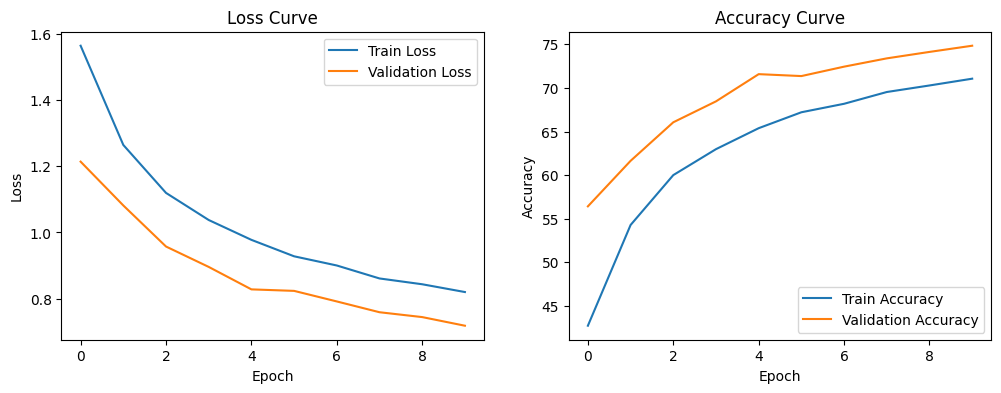

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import torch

# Inference
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))



Test Accuracy: 74.84%

Classification Report:

              precision    recall  f1-score   support

    airplane       0.71      0.83      0.76      1000
  automobile       0.87      0.83      0.85      1000
        bird       0.70      0.57      0.63      1000
         cat       0.57      0.57      0.57      1000
        deer       0.69      0.73      0.71      1000
         dog       0.70      0.62      0.66      1000
        frog       0.76      0.85      0.81      1000
       horse       0.83      0.78      0.80      1000
        ship       0.83      0.87      0.85      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [1]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Correct vs Incorrect Predictions
correct_samples = np.array(all_preds) == np.array(all_labels)

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Correctly Classified vs Misclassified Samples')

correct_idx = np.where(correct_samples)[0][:5]
wrong_idx = np.where(~correct_samples)[0][:5]

# Display Correct Predictions
for i, idx in enumerate(correct_idx):
    img, label = test_dataset[idx]
    axs[0, i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    axs[0, i].set_title(f"True: {test_dataset.classes[all_labels[idx]]}\nPred: {test_dataset.classes[all_preds[idx]]}")
    axs[0, i].axis('off')

# Display Incorrect Predictions
for i, idx in enumerate(wrong_idx):
    img, label = test_dataset[idx]
    axs[1, i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    axs[1, i].set_title(f"True: {test_dataset.classes[all_labels[idx]]}\nPred: {test_dataset.classes[all_preds[idx]]}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a transform similar to test set
user_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_user_image(img_path, model):
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    input_tensor = user_transform(img).unsqueeze(0).to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        pred_class = test_dataset.classes[predicted.item()]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Model Prediction: {pred_class}")
    plt.axis('off')
    plt.show()

predict_user_image("car.jpg", model)